In [1]:
import time

import torch
import torch.nn as nn
import torch.nn.functional as F

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
device

device(type='cpu')

In [4]:
import src.ChebNet as ChebNet
import src.CORA as CORA
import src.utils as utils

In [5]:
# Reload when files are changed
import importlib
importlib.reload(ChebNet)
importlib.reload(CORA)
importlib.reload(utils)

<module 'src.utils' from '/Users/alice/Documents/GIT/CayleyNets/src/utils.py'>

In [6]:
# Import dataset
cora = CORA.CORA()

Parsing files...
Done.


In [7]:
# Print properties of the dataset
dataset = cora
print(dataset.description)
print(f'Number of nodes: {dataset.n}')
print(f'Number of edges: {dataset.n_edges}')
print(f'Number of features per node: {dataset.n_features}')

CORA dataset
Number of nodes: 2708
Number of edges: 10556
Number of features per node: 1433


In [8]:
# Extended split of the CORA dataset
train_mask, test_mask, val_mask = utils.split_train_test_val(dataset.n, 500, 500) 

In [9]:
# Features and labels as tensors
features = torch.Tensor(1.0*dataset.features).to(device)
labels = torch.Tensor(dataset.labels).long().to(device)
edge_index = dataset.get_edge_index().to(device)

# Masks as tensors
train_mask = torch.Tensor(train_mask).bool().to(device)
test_mask = torch.Tensor(test_mask).bool().to(device)
val_mask = torch.Tensor(val_mask).bool().to(device)

In [12]:
# Hyperparameters (Section 4.5)
in_feats = dataset.n_features
n_classes = dataset.n_classes
n_hidden = 16
n_hidden_layers = 1 # number of hidden layers
k = 10 # Chebshev polynomial order 
# obs: we weren't able to identify the value of this last parameter in the paper, only that k=2*r where r is the Cayley polynomial order

In [13]:
p_dropout=0.5
normalization = 'sym'
model = ChebNet.ChebNet(in_feats, n_classes, n_hidden, n_hidden_layers, k=k, p_dropout=p_dropout, normalization=normalization)

In [14]:
print(model)
print(f'Number of parameters: {sum(p.numel() for p in model.parameters())}')
print(f'Number of parameters: {sum(p.numel() for p in model.layers[0].parameters())}')
print(f'Number of parameters: {sum(p.numel() for p in model.layers[1].parameters())}')           

ChebNet(
  (layers): ModuleList(
    (0): ChebConv(1433, 16, K=10, normalization=sym)
    (1): ChebConv(16, 7, K=10, normalization=sym)
  )
)
Number of parameters: 230400
Number of parameters: 229280
Number of parameters: 1120


In [15]:
# Optimizer
lr = 5e-3
weight_decay = 5e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

In [16]:
# Train the model
batch_size = 32
epochs = 200

# save loss values for plotting
loss_values = []
val_score = []
train_score = []

verbose = True
for e in range(epochs):
    start = time.time()

    # Compute output
    logp = model(features, edge_index)

    # Compute loss
    loss = F.nll_loss(logp[train_mask], labels[train_mask])
    loss_values.append(loss.item())

    # Perform backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Evaluation
    score = utils.eval_pytorch_geometric_model(model, edge_index, features, labels, train_mask)
    train_score.append(score)

    score = utils.eval_pytorch_geometric_model(model, edge_index, features, labels, val_mask)
    val_score.append(score)

    # Print loss
    end = time.time()
    if verbose:
        print("Epoch {:02d} | Loss {:.3f} | Accuracy (validation) {:.3f} | Elapsed time: {:.2f}s".format(e, loss.item(), score, end - start))

Epoch 00 | Loss 2.508 | Accuracy (validation) 0.184 | Elapsed time: 0.86s
Epoch 01 | Loss 1.875 | Accuracy (validation) 0.228 | Elapsed time: 0.61s
Epoch 02 | Loss 1.740 | Accuracy (validation) 0.280 | Elapsed time: 0.61s
Epoch 03 | Loss 1.582 | Accuracy (validation) 0.314 | Elapsed time: 0.61s
Epoch 04 | Loss 1.439 | Accuracy (validation) 0.340 | Elapsed time: 0.63s
Epoch 05 | Loss 1.306 | Accuracy (validation) 0.374 | Elapsed time: 0.62s
Epoch 06 | Loss 1.151 | Accuracy (validation) 0.416 | Elapsed time: 0.66s
Epoch 07 | Loss 1.022 | Accuracy (validation) 0.440 | Elapsed time: 0.62s
Epoch 08 | Loss 0.919 | Accuracy (validation) 0.452 | Elapsed time: 0.68s
Epoch 09 | Loss 0.797 | Accuracy (validation) 0.470 | Elapsed time: 0.64s
Epoch 10 | Loss 0.675 | Accuracy (validation) 0.466 | Elapsed time: 0.66s
Epoch 11 | Loss 0.577 | Accuracy (validation) 0.484 | Elapsed time: 0.62s
Epoch 12 | Loss 0.471 | Accuracy (validation) 0.520 | Elapsed time: 0.67s
Epoch 13 | Loss 0.374 | Accuracy (vali

In [17]:
test_score = utils.eval_pytorch_geometric_model(model, edge_index, features, labels, test_mask)
print("Test accuracy {:.3f}".format(test_score))

Test accuracy 0.810


In [18]:
results = {'model': 'ChebNet',
           'dataset': dataset.name,
           'training size': len(train_mask),
           'validation size': len(val_mask),
           'test size': len(test_mask),
           'n hidden nodes': n_hidden,
           'n hidden layers': n_hidden_layers,
           'polynomial order': r,
           'laplacian normalization': normalization,
           'dropout probability': p_dropout,
           'learning rate': lr,
           'weight decay': weight_decay,
           'batch size': batch_size,
           'n epochs': epochs,
           'loss': loss_values,
           'train accuracy': train_score,
           'validation accuracy': val_score,
           'test accuracy': test_score
           }

In [19]:
import pickle
import datetime
ts = datetime.datetime.now()
ts = '{}-{}-{}-{}-{}-{}'.format(ts.year, ts.month, ts.day, ts.hour, ts.minute, ts.second)
fname = './results/cheb_{}.pkl'.format(ts)
with open(fname, 'wb') as f:
    pickle.dump(results, f)
        
with open(fname, 'rb') as f:
    loaded_results = pickle.load(f)

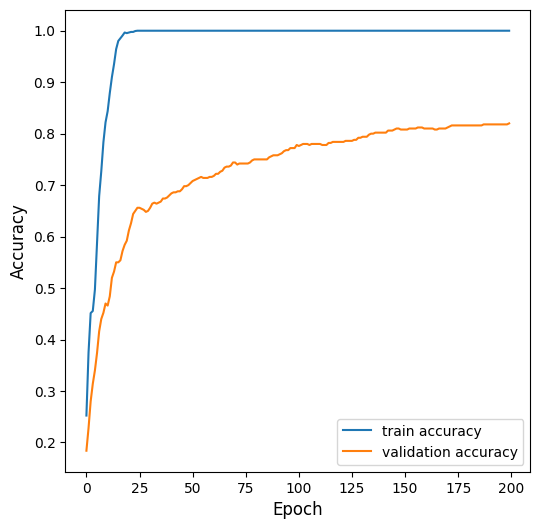

In [20]:
utils.plot_accuracy(loaded_results['train accuracy'], loaded_results['validation accuracy'])

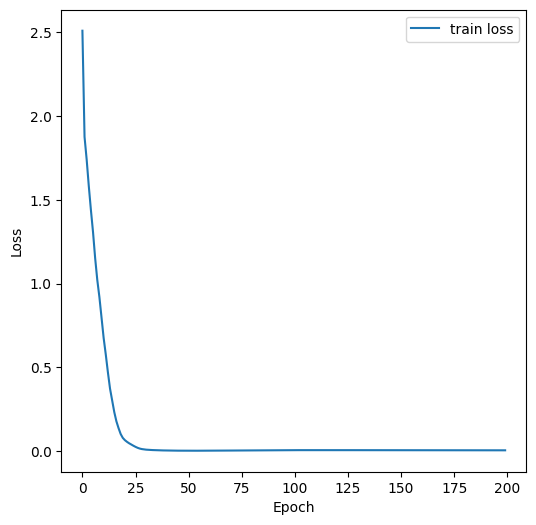

In [21]:
utils.plot_loss(loaded_results['loss'])

In [22]:
print("Test accuracy {:.3f}".format(loaded_results['test accuracy']))

Test accuracy 0.810
